# CDC 2024 Benchmark

# This file runs different simulations and generates comparative results between vanilla FLPO implementation and time-invariant FLPO implementation

In [6]:
# import all the packages
from numpy import *;
import numpy as np;
import matplotlib.pyplot as plt; plt.rcParams.update(plt.rcParamsDefault);
import itertools;
import math;
import scipy.io as scio;
import copy;
import time;
import pickle;
from scipy.optimize import minimize;
from matplotlib import patches;
import warnings;
from scipy.spatial.distance import cdist;
from scipy.optimize import LinearConstraint
from scipy.special import *

# Generate Data

# config parameters

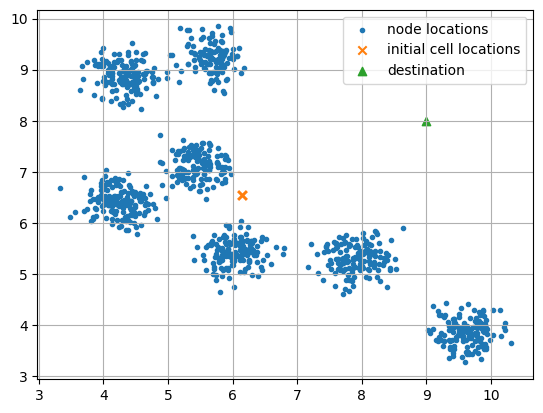

In [20]:
def generate_dataset(n, cov, k, scale,seed=0):
    # Generate random means for each cluster
    np.random.seed(seed)
    means = np.random.rand(k, 2)*scale

    # Generate random points in k clusters
    nodes = np.zeros((n, 2))
    for i in range(n):
        cluster = np.random.randint(0, k)  # Choose a random cluster
        nodes[i] = np.random.multivariate_normal(means[cluster], cov)
    Y_s = np.tile(np.sum(nodes, axis=0), (k,1))/n
    dest = np.array([[0.9,0.8]])*scale
    return nodes,Y_s,dest

# Example usage
n = 1000  # Total number of points
var = 7e-3 # variance of each cluster
scale=10
cov = np.eye(2) * var * scale # Covariance matrix
k = 7  # Total number of clusters
nodes, Y_s, dest = generate_dataset(n, cov, k, scale=scale,seed = 0)
plt.scatter(nodes[:,0],nodes[:,1],marker='.')
plt.scatter(Y_s[:,0],Y_s[:,1],marker='x')
plt.scatter(dest[:,0],dest[:,1],marker='^')
plt.grid()
plt.legend(['node locations','initial cell locations','destination'])
plt.show()
smallCellNetdata = {'numNodes':n, 'numFacilities':k, 'nodeLocations':nodes, 'cellLocations':Y_s, 'destinationLocation':dest}
filename = 'smallCellNetData.pkl';

with open(filename, 'wb') as file:
    pickle.dump(smallCellNetdata, file)

In [22]:

N_scenarios = 1 # number of different scenarios to benchmark on

n = 1000 # Total number of points
var = 7e-3 # variance of each cluster
scale = 10
cov = np.eye(2) * var * scale # Covariance matrix
Scenarios = []
M_values = [5,] # Number of facilities
for i in range(N_scenarios):
    for M in M_values:
        nodes, Y_s, dest = generate_dataset(n, cov, M, scale=scale, seed = i)
        smallCellNetdata = {'numNodes':n, 'numFacilities':M, 'nodeLocations':nodes, 'cellLocations':Y_s, 'destinationLocation':dest}
        filename = 'smallCellNetData_'+str(i).zfill(2)+'_'+str(M).zfill(2)+'.pkl';
        with open(filename, 'wb') as file:
            pickle.dump(smallCellNetdata, file)
        Scenarios.append(filename)

# Environment Setup


# Class and Function Definition

# Finite Horizon Stagewise FLPO

In [23]:
my_inf=1e6
def my_log(m):
    return log(m, out=np.zeros_like(m), where=(m>0))
def penalty(x):
    mask = x<=0
    y = my_inf*(x**2)
    y[mask] = 0
    return y

def return_arc_length(points, center, r): # so far calculating euclidean distance!!!!!!!!!!!!!!
    x1, y1 = points[0]
    x2, y2 = points[1]
    c_x, c_y = center
    if x1==x2 and y1==y2:
        return 0.0
    # Calculate the distance between the center of the circle and the line segment
    dist = np.abs((y2 - y1) * c_x - (x2 - x1) * c_y + x2 * y1 - x1 * y2) / np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    # Check if the distance is less than or equal to the radius
    if dist < r:
        d = 2 * np.sqrt(r ** 2 - dist ** 2)
        l = 2*r*math.atan(d/math.sqrt(4*r**2-d**2+1e-10))
        return l-d
    else:
        return 0.0
def add_block_dist(center,r):
  return lambda u,v:return_arc_length([u,v],center,r)

# Function to check if line segment intersects circle and calculate intersection points
def line_circle_intersection(circle_center, radius, line_start, line_end):
    circle_center = np.array(circle_center)
    line_start = np.array(line_start)
    line_end = np.array(line_end)
    d = line_end - line_start
    f = line_start - circle_center
    a = np.dot(d, d)
    b = 2 * np.dot(f, d)
    c = np.dot(f, f) - radius**2
    discriminant = b**2 - 4 * a * c
    if discriminant < 0:
        return None

    discriminant = np.sqrt(discriminant)
    t1 = (-b - discriminant) / (2 * a+1e-8)
    t2 = (-b + discriminant) / (2 * a+1e-8)

    if not (0 <= t1 <= 1 or 0 <= t2 <= 1):
        return None

    intersection1 = line_start + t1 * d
    intersection2 = line_start + t2 * d

    return intersection1, intersection2

# Function to calculate the shorter arc between two points on a circle
def calculate_shorter_arc(circle_center, radius, point1, point2):
    def to_polar(point):
        x, y = point - circle_center
        return np.arctan2(y, x)

    theta1 = to_polar(point1)
    theta2 = to_polar(point2)

    if theta1 > theta2:
        theta1, theta2 = theta2, theta1

    arc_length1 = theta2 - theta1
    arc_length2 = 2 * np.pi + theta1 - theta2

    if arc_length1 < arc_length2:
        return theta1, theta2
    else:
        return theta2, theta1 + 2 * np.pi

# Function to get the path segments for each drone
def get_drone_path_segments(drone, route, stations):
    path_segments = []
    current_location = drone[0]

    for station_index in route:
        if station_index == len(stations):
            next_location = drone[1]
        else:
            next_location = stations[station_index]

        path_segments.append((current_location, next_location))
        current_location = next_location

    return path_segments

def normalize_drones(drones):
    lb=np.min([np.min((drone[0],drone[1])) for drone in drones])
    ub=np.max([np.max((drone[0],drone[1])) for drone in drones])
    normalized_drones = [(((x1 - lb) / (ub - lb), (y1 - lb) / (ub - lb)),
                          ((x2 - lb) / (ub - lb), (y2 - lb) / (ub - lb)),
                          charge)
                         for ((x1, y1), (x2, y2), charge) in drones]

    return normalized_drones, (lb,ub)

def denormalize_drones(normalized_drones, min_max_values):
    lb, ub = min_max_values

    # Denormalize coordinates
    denormalized_drones = [(((x1 * (ub - lb) + lb), (y1 * (ub - lb) + lb)),
                             ((x2 * (ub - lb) + lb), (y2 * (ub - lb) + lb)),
                             charge)
                            for ((x1, y1), (x2, y2), charge) in normalized_drones]

    return denormalized_drones

def normalize_blocks(blocks,min_max_values):
    lb, ub = min_max_values
    normalized_blocks = [(((x - lb) / (ub - lb), (y - lb) / (ub - lb)),
                          r/(ub - lb))
                         for ((x, y), r) in blocks]
    return normalized_blocks
def denormalize_blocks(blocks,min_max_values):
    lb, ub = min_max_values
    denormalized_blocks = [(((x * (ub - lb) + lb), (y * (ub - lb) + lb)),

                             r* (ub - lb))
                            for ((x, y), r) in blocks]
    return denormalized_blocks

class uav_flpo:
    def __init__(self,drones,num_stations,blocks=None,
                 ugv_factor=0.0,fcr=25,distance='euclidean') -> None:
        super().__init__()
        self.den_drones = drones
        self.drones,lb_ub = normalize_drones(drones)
        self.lb,self.ub = lb_ub
        self.scale = self.ub-self.lb
        self.stations=np.repeat([0.5,0.5],num_stations,axis=0)
        if blocks is not None:
          self.blocks=normalize_blocks(blocks,lb_ub)
        else:
          self.blocks=None
        self.N_drones= len(drones)
        self.N_stations=num_stations
        self.stage_horizon=self.N_stations+1
        self.gamma_k_length=self.N_stations+1
        self.fcr=fcr/self.scale
        self.distance=distance
        self.ugv_factor=ugv_factor
        self.bounds = [(0, 1)]*self.N_stations*2
        self.cost_normalizer = 1/(self.N_drones*(self.N_stations**self.N_stations))
        return

    def return_stagewise_cost(self,params,beta): #params is like stations
        d_F=cdist(params,params,self.distance)
        if not self.blocks==None:
            for block in self.blocks:
                d_F=d_F+cdist(params,params,metric=add_block_dist(block[0],block[1]))
        d_F=d_F+diag([my_inf]*self.N_stations)
        d_delta_to_f=array([my_inf]*self.N_stations).reshape(1,-1)
        d_df=np.concatenate((d_F,d_delta_to_f),axis=0)
        D_ss=[0]*self.N_drones
        for drone_id,drone in enumerate(self.drones):
            stage=concatenate((params,array(self.drones[drone_id][1]).reshape(1,-1)),axis=0)
            D_s=[0]*(self.stage_horizon+1)
            stage_0=array(self.drones[drone_id][0]).reshape(1,-1)
            D_s[0]=cdist(stage_0,stage,self.distance)
            if not self.blocks==None:
                for block in self.blocks:
                    D_s[0]=D_s[0]+cdist(stage_0,stage,metric=add_block_dist(block[0],block[1]))
            #print(D_s[0]-self.drones[drone_id][2]*self.fcr)
            D_s[0]=D_s[0]+penalty(D_s[0]-self.drones[drone_id][2]*self.fcr)
            #D_s[0]=D_s[0]+my_exp(beta*(D_s[0]-self.drones[drone_id][2]*self.fcr))
            #D_s[0][0,-1]=D_s[0][0,-1]*(D_s[0][0,-1]>my_inf)

            delta_id= self.N_stations+drone_id
            # so far we have taken care of the first distance matrix

            d_f_to_delta=cdist(params,array(self.drones[drone_id][1]).reshape(1,-1),self.distance)
            if not self.blocks==None:
                for block in self.blocks:
                    d_f_to_delta=d_f_to_delta+cdist(params,array(self.drones[drone_id][1]).reshape(1,-1),metric=add_block_dist(block[0],block[1]))
            d_last=np.concatenate((d_f_to_delta,array([0]).reshape(1,-1)),axis=0)
            d=np.concatenate((d_df,d_last),axis=1)


            d=d+(penalty(d-self.fcr))
            #d=d+my_exp(beta*(d-self.fcr))
            D_s[1:self.stage_horizon] = [d] * (self.stage_horizon - 1)
            d_l=[my_inf]*(self.gamma_k_length-1)
            d_l.append(0.0)
            D_s[-1]=array(d_l).reshape(-1,1)
            D_ss[drone_id]=D_s
        self.D_ss=D_ss
        return
        
    def calc_associations(self,beta):
        p=[]
        self.return_stagewise_cost(self.params.reshape(-1,2),beta)
        D_ss=self.D_ss
        for D_s in D_ss:
            K=len(D_s)
            D=D_s[::-1]
            out_D=[0]*(K+1)
            out_D[0]=array([0.0]).reshape(-1,1)
            out_p=[0]*(K+1)
            out_p[0]=array([1.0]).reshape(-1,1)
            out=[0]*(K+1)
            out[0]=array([1.0]).reshape(-1,1)
            for i in range(1,K+1):
                out_D[i]=(D[i-1]+repeat(transpose(out_D[i-1]),D[i-1].shape[0],axis=0))
                m=out_D[i].min(axis=1,keepdims=True)
                exp_D=exp(multiply(-beta,out_D[i]-m))
                out[i]=sum(multiply(exp_D,tile(out[i-1], (1,D[i-1].shape[0])).T),axis=1,keepdims=True)
                out_p[i]=divide(multiply(exp_D,out[i-1].T),out[i])
                out_D[i]=m
            p.append(out_p[::-1][:-1])
        self.P_ss=p
        return

    def free_energy(self,D_s,P_s,beta):
        '''
        input: D_s: a list of K numpy arrays corrosponding to distances between stages
        P_s: a list of K numpy arrays corrosponding to probabilities between stages

        output: out_c: K+1 numpy arrays with shape[1]=1, indicating the total cost of nodes
        '''

        K=len(D_s)
        D=D_s[::-1]
        P=P_s[::-1]
        out_P=[0]*(K+1)
        out_C=[0]*(K+1)
        out_H=[0]*(K+1)
        out_P[0]=array([1.0]).reshape(-1,1)
        out_C[0]=array([0.0]).reshape(-1,1)
        out_H[0]=array([0.0]).reshape(-1,1)
        for i in range(1,K+1):
          # assigning P of each node for calculating C in the next i
          out_P[i]=(P[i-1]*repeat(transpose(out_P[i-1]),P[i-1].shape[0],axis=0)).sum(axis=1).reshape(-1,1)
          out_C[i]=(P[i-1]*(D[i-1]*repeat(transpose(out_P[i-1]),D[i-1].shape[0],axis=0)+repeat(transpose(out_C[i-1]),D[i-1].shape[0],axis=0))).sum(axis=1).reshape(-1,1)
          out_H[i]=-(P[i-1]*(my_log(P[i-1])*repeat(transpose(out_P[i-1]),D[i-1].shape[0],axis=0)-repeat(transpose(out_H[i-1]),D[i-1].shape[0],axis=0))).sum(axis=1).reshape(-1,1)
        # D-1/beta*H
        return (out_C[-1].T).sum() + (-1/beta)*(out_H[-1].T).sum()
        
    def free_energy_Gibbs(self,D_s,beta):
        K=len(D_s)
        D=D_s[::-1]
        out_D=[0]*(K+1)
        out_D[0]=array([0.0]).reshape(-1,1)
        out=[0]*(K+1)
        out[0]=array([1.0]).reshape(-1,1)
        for i in range(1,K+1):

            out_D[i]=(D[i-1]+repeat(transpose(out_D[i-1]),D[i-1].shape[0],axis=0))

            m=out_D[i].min(axis=1,keepdims=True)
            exp_D=exp(multiply(-beta,D[i-1]))
            out[i]=sum(multiply(exp_D,tile(out[i-1], (1,D[i-1].shape[0])).T),axis=1,keepdims=True)
            out_D[i]=m
        if isclose(out[-1],0.0).all():
            return m.sum()
        else:
            return (-1/beta*log(out[-1]).sum())

    def objective(self,params,beta):
        self.return_stagewise_cost(params.reshape(-1,2),beta)
        cost=0
        for i in range(len(self.D_ss)):
            cost+=self.free_energy_Gibbs(self.D_ss[i],beta)
        if self.ugv_factor == 0.0:
            return self.cost_normalizer*cost
        else:
            return self.cost_normalizer*cost+self.ugv_factor*linalg.norm(params.reshape(-1,2)-self.stations)

    def optimize_D(self,init_guess,beta,method):
        # bounds=(np.min([np.min(drone[0]+drone[1]) for drone in drones]),np.max([np.max(drone[0]+drone[1]) for drone in drones]))*len(init_guess)
        result = minimize(self.objective, init_guess,args=(beta,),bounds=self.bounds,method=method)
        self.params = result.x
        self.cost_fun=result.fun
    def calc_routs(self):
        O=[]
        for i in range(self.N_drones):
          m=0
          o=[]
          for p in self.P_ss[i]:
              m=argmax(p[m,:])
              o.append(m)
          o.pop()
          O.append(o)
        self.routs=O

    def train(self,beta_init=1e-6,beta_f=100,alpha=1.5,purturb=0.1,method='powell',verbos=0):
        self.Y_s=[]
        self.Betas=[]
        self.params=ndarray.flatten(self.stations)
        beta=beta_init
        # self.return_stagewise_cost(self.params.reshape(-1,2))
        old_cost=my_inf
        while beta <= beta_f:
            count=0
            self.params=self.params+np.random.normal(0, purturb, self.params.shape)

            self.optimize_D(self.params,beta,method=method) #based on P_ss
            count+=1
            if verbos:
              print(f'Beta: {beta:.4e}  Cost: {self.cost_fun:0.5e}')
            if abs(self.cost_fun-old_cost)/abs(old_cost) <= 1e-4:
                print("--Optimization Terminated--")
                break
            old_cost=self.cost_fun
            beta=beta*alpha
            self.Y_s.append(self.params.reshape(-1,2))
            self.Betas.append(beta)
        self.calc_associations(beta)
        self.calc_routs()

    def print_routs(self):
        print("")
        for i,o in enumerate(self.routs):
          print(f'\nDrone {i+1} --->', end='')
          for j in o:
            if j<env.N_stations:
              print(f'f{j+1} --->', end='')
            else:
              print(f'[D{i+1}]', end='')
              break

    def return_total_cost(self):
        return self.cost_fun/self.cost_normalizer*self.scale*self.scale

    def return_direct_cost(self):
        return np.sum([np.sum((np.array(drone[0])-np.array(drone[1]))**2)**0.5 for drone in self.den_drones])

    def plot_routs(self,show_info=True,show_nums=True,save=False,show_ugv=False):
        state_locs=self.params.reshape(-1,2).copy()*self.scale+self.lb
        den_drones = self.den_drones
        drone_locs=array([i[0] for i in den_drones])
        dest_locs=array([i[1] for i in den_drones])
        plt.scatter(drone_locs[:,0],drone_locs[:,1],color='black',label='User Nodes')
        for i, loc in enumerate(drone_locs):
            if show_info:
                plt.text(loc[0], loc[1], 'V'+str(i+1)+f' ({self.drones[i][2]})', ha='center', va='bottom')
        plt.scatter(state_locs[:,0],state_locs[:,1],marker='^',label='Cell Towers')
        f_indices = np.argsort(state_locs[:,0])
        for i, loc in enumerate(state_locs):
            if show_info:
                plt.text(loc[0], loc[1], 'F'+str(i+1), ha='center', va='bottom')
        plt.scatter(dest_locs[:,0],dest_locs[:,1],marker='*',label='Dest.')
        for i, loc in enumerate(dest_locs):
            if show_info:
                plt.text(loc[0]+1*np.random.rand()*(-1)**round(np.random.rand()), loc[1]+1*np.random.rand(), 'D'+str(i+1), ha='center', va='bottom')
        options = ['-', '--', '-.', ':',]
        modified_lines = []
        colors = []
        styles = []
        for i, o in enumerate(self.routs):

            line_style=np.random.choice(options)
            styles.append(line_style)
            drone_loc = drone_locs[i]
            try:
              state_loc = state_locs[o[0]]
            except:
              state_loc=dest_locs[i]
            color=np.random.rand(3)
            colors.append(color)
            plt.plot([drone_loc[0], state_loc[0]], [drone_loc[1], state_loc[1]], color=color,linewidth=1.5,linestyle=line_style)
            dist = np.sqrt(np.sum((drone_loc - state_loc) ** 2))
            col='red' if dist > self.drones[i][2]*self.fcr*self.scale else 'green'
            if dist >0.0:
              if show_nums:
                plt.text((drone_loc[0] + state_loc[0]) / 2, (drone_loc[1] + state_loc[1]) / 2, f'{dist:.2f}', color=col, ha='center')
            if len(o)>1:
              for j in range(len(o) - 1):
                  try:
                    loc1 = state_locs[o[j]]
                  except:
                    loc1 = dest_locs[i]
                  try:
                    loc2 = state_locs[o[j + 1]]
                  except:
                    loc2=dest_locs[i]
                  plt.plot([loc1[0], loc2[0]], [loc1[1], loc2[1]], color=color,linewidth=1.5,linestyle=line_style)
                  dist = np.sqrt(np.sum((loc1 - loc2) ** 2))
                  col='red' if dist > self.fcr*self.scale else 'green'
                  if dist>0.0:
                    if show_nums:
                      plt.text((loc1[0] + loc2[0]) / 2, (loc1[1] + loc2[1]) / 2, f'{dist:.2f}', color=col, ha='center')
        if not self.blocks==None:
            counter=0
            den_blocks = denormalize_blocks(self.blocks,(self.lb,self.ub))
            for center, radius in den_blocks:
                c_x, c_y = center
                label='Obst.' if counter==0 else None
                circle=patches.Circle(center, radius,edgecolor="white", linewidth=0.05,facecolor='grey', linestyle='-',label=label)
                circle.set_zorder(2)
                plt.gca().add_patch(circle)
                counter+=1
        ax = plt.gca()

        # Process each drone, but only draw the arcs this time
        if not self.blocks==None:
          counter = 0
          label=None
          drone_id=0
          for drone, route in zip(den_drones, self.routs):
              path_segments = get_drone_path_segments(drone, route, state_locs)
              for segment in path_segments:
                  for block in den_blocks:
                      intersections = line_circle_intersection(block[0], block[1], segment[0], segment[1])
                      if intersections:
                          if counter==0:
                              label='Adj.'
                              counter +=1
                          theta_start, theta_end = calculate_shorter_arc(block[0], block[1], intersections[0], intersections[1])
                          arc = patches.Arc(block[0], 2*block[1], 2*block[1],
                                                      theta1=np.degrees(theta_start), theta2=np.degrees(theta_end),
                                                      color=colors[drone_id],linewidth=3, linestyle=styles[drone_id])
                          ax.add_patch(arc)
                      label=None
              drone_id +=1
        if show_ugv:
            plt.scatter(self.stations[0,0],self.stations[0,1],color='orange',marker='2')
            plt.text(self.stations[0,0], self.stations[0,1], 'Initial UGV location', ha='center', va='bottom')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.grid()
        plt.title(r'Finite Horizon Time-Variant Implementation')
        # plt.title(f'M={self.N_stations} F.C.R. = {self.fcr*self.scale}')
        plt.gca().set_aspect('equal')

        if save:
          plt.savefig(r'sim res for M={self.N_stations} F.C.R. = {self.fcr*self.scale}.pdf')
        plt.show()

# Infinite Horizon ParaSDM FLPO

In [24]:
#define the model here as a class
tol=1e-8;
class SmallCellNet():

    #firstly define the data member for the model
    n: int; #number of nodes,
    f: int; #number of cell towers;
    nodeLocations: np.ndarray; #nx2 matrix including the node coordinates (fixed)
    cellLocations: np.ndarray; #fx2 matrix storing the cell-tower locations (changable)
    destinationLocation: np.ndarray; #1x2 matrix storing the destination location (fixed)#
    st:int;
    reward2cost:int;

    #define a probability transition matrix for the model.... (s,a) -> nextState
    P:np.ndarray;
    #define a cost function matrix for the transition (s,a) -> nextState
    C:np.ndarray;
    #define a gradient matrix wrt for each (s, a, s') for each parameters
    G:np.ndarray;
    #define a an action mask sxa dimensional matrix
    action_mask:np.ndarray;


    #define the constructor
    def __init__(self, filename:str, init_state=0):
        '''
        function initializes the small cell network model.
        n: number of starting nodes,
        f: number of intermediate cell-towers
        location_path: path to a mat file to get the node, destination and initialize the cell tower locations
        '''

        #now load the mat file from the path and get the locations
        with open(filename, 'rb') as df:
            data = pickle.load(df)

        self.n = data['numNodes'];
        self.f = data['numFacilities'];
        self.nodeLocations = data['nodeLocations'];
        self.destinationLocation = data['destinationLocation'];
        self.st = init_state;
        self.init_params(); #initialize parameters through the function

        #fnally define the state and action space for the model
        self.state_space = [(s,) for s in np.linspace(0, self.n+self.f**2, self.n+self.f**2+1, dtype = int)];
        self.action_space = [(a,) for a in np.linspace(0, self.f**2, self.f**2+1, dtype = int)];

        #finally initialize the probability, cost, action mask and gradient tensors..
        self.init_state_distribution();
        self.init_probab_matrix();
        self.init_cost_matrix();
        self.init_action_mask();
        self.init_grad_matrix();

    # define a function to compute initial state distribution
    def init_state_distribution(self):
        '''
        function computes a distribution for initialization of states
        For FLPO, the support of the distribution is only on the nodal states
        '''
        # initialze as zeros, define uniformly over the nodes, normalize
        rho = np.zeros(*self.state_space_shape());
        rho[1+self.f**2:] = np.ones(self.n);
        self.rho = rho/np.sum(rho);

        pass;

    #define a function to initialize the probability transition
    def init_probab_matrix(self): ##Exclusive to the matricized version of the algorithm
        '''
        function initializes the probability transition matrix for matriced algorithms
        probability transition matrix is sxaxs dimensional tensor (3d tensor)
        '''
        #start with an initial zeros matrix
        #now for any state action pair, we must assign the corresponding probability of going to the next state
        #w.p 0.9 goto the state mentioned in the action
        self.P = np.tile(np.expand_dims(np.eye(*self.act_space_shape(),*self.state_space_shape()), axis=0), (*self.state_space_shape(),1,1));
        #and the destination gets an additional 0.1 probability....bcoz we goto destinaition with probability 0.1
        # self.P[:,:,0] += 0.1;
        pass;

    #define a function to initialize the cost matrix
    def init_cost_matrix(self):
        big_cost = 100.0
        # initialize the cost matrix at very high cost for all state-action pairs
        C = big_cost*np.ones(shape = (*self.state_space_shape(),*self.state_space_shape()))
        # compute lower dimensional cost matrix of the original FLPO problem as intermediate cost
        C_interm = cdist(self.X, self.X, metric='sqeuclidean')
        # incentivize all transition from the facilities to destination;
        C_interm[1:self.f+1,0] -= 0;

        # pick sections of intermediate cost
        Cf2f = C_interm[1:self.f+1, 1:self.f+1]; # facilities to facilities
        Cf2d = C_interm[1:self.f+1, 0]; # facilities to destination
        Cn2f = C_interm[1+self.f:1+self.f+self.n, 1:1+self.f]; # nodes to facilities
        Cn2d = C_interm[1+self.f:, 0]

        # now fill the higher dimensional cost matrix with the values of intermediate costs for allowable transitions
        for p in range(self.f+2):
            if p == 0:
                # from destination
                C[0,0] = 0; # to destination only
            elif p == 1:
                # from FLPO stage 1 facilities
                C[1:1+self.f, 0] = Cf2d; # to destination
                C[1:1+self.f, 1+self.f:1+2*self.f] = Cf2f; # to FLPO stage 2 facilities
            elif p < self.f and p > 1:
                # from FLPO stage p facilities
                C[1+(p-1)*self.f:1+p*self.f, 0] = Cf2d # to destination
                C[1+(p-1)*self.f:1+p*self.f, 1+p*self.f:1+(p+1)*self.f] = Cf2f # to FLPO stage p+1 facilities
            elif p == self.f:
                # from FLPO final stage facilities
                C[1+(p-1)*self.f:1+p*self.f, 0] = Cf2d # to destination only
            elif p == self.f+1:
                # from FLPO nodes
                C[1+(p-1)*self.f:1+(p-1)*self.f+self.n, 1:1+self.f] = Cn2f # to destination
                C[1+(p-1)*self.f:1+(p-1)*self.f+self.n, 0] = Cn2d

                

        # expand the cost matrix to define it for each action as well
        self.C = np.tile(np.expand_dims(C, axis=1), (1, *self.act_space_shape(), 1));
        pass;

    #define a function to update cost matrix..after change of parameters
    def update_cost_matrix(self):
        big_cost = 100.0
        # initialize the cost matrix at very high cost for all state-action pairs
        C = big_cost*np.ones(shape = (*self.state_space_shape(),*self.state_space_shape()))
        # compute lower dimensional cost matrix of the original FLPO problem as intermediate cost
        C_interm = cdist(self.X, self.X, metric='sqeuclidean')
        # incentivize all transition from the facilities to destination;
        C_interm[1:self.f+1,0] -= 0;

        # pick sections of intermediate cost
        Cf2f = C_interm[1:self.f+1, 1:self.f+1]; # facilities to facilities
        Cf2d = C_interm[1:self.f+1, 0]; # facilities to destination
        Cn2f = C_interm[1+self.f:1+self.f+self.n, 1:1+self.f]; # nodes to facilities
        Cn2d = C_interm[1+self.f:, 0]

        # now fill the higher dimensional cost matrix with the values of intermediate costs for allowable transitions
        for p in range(self.f+2):
            if p == 0:
                # from destination
                C[0,0] = 0; # to destination only
            elif p == 1:
                # from FLPO stage 1 facilities
                C[1:1+self.f, 0] = Cf2d; # to destination
                C[1:1+self.f, 1+self.f:1+2*self.f] = Cf2f; # to FLPO stage 2 facilities
            elif p < self.f and p > 1:
                # from FLPO stage p facilities
                C[1+(p-1)*self.f:1+p*self.f, 0] = Cf2d # to destination
                C[1+(p-1)*self.f:1+p*self.f, 1+p*self.f:1+(p+1)*self.f] = Cf2f # to FLPO stage p+1 facilities
            elif p == self.f:
                # from FLPO final stage facilities
                C[1+(p-1)*self.f:1+p*self.f, 0] = Cf2d # to destination only
            elif p == self.f+1:
                # from FLPO nodes
                C[1+(p-1)*self.f:1+(p-1)*self.f+self.n, 1:1+self.f] = Cn2f # to facilities
                C[1+(p-1)*self.f:1+(p-1)*self.f+self.n, 0] = Cn2d

        # expand the cost matrix to define it for each action as well
        self.C = np.tile(np.expand_dims(C, axis=1), (1, *self.act_space_shape(), 1));
        pass;

    #define a function to iniitalize the gradient wrt parameters for each sxaxs combintation
    def init_grad_matrix(self):
        '''
        initialize the gradient w.r.t parameter tensor which is a state x action x nextState x parameter dimensional tensor..
        '''
        # initialize lower dimensional gradient matrix
        Gtemp = np.zeros(shape = (self.f+self.n+1, self.f+self.n+1, len(self.parameters())));
        # initialize higher dimensional gradient matrix
        G = np.zeros(shape = (*self.state_space_shape(), *self.state_space_shape(), len(self.parameters())));

        # fill up the values for the lower dimensional gradient matrix
        for p in range(self.f):
            Gtemp[p+1,:,2*p] = (self.X[p+1,0] - self.X[:,0])*2;
            Gtemp[p+1,:,(2*p)+1] = (self.X[p+1,1] - self.X[:,1])*2;
            Gtemp[:,p+1,2*p] = (self.X[p+1,0] - self.X[:,0])*2;
            Gtemp[:,p+1,(2*p)+1] = (self.X[p+1,1] - self.X[:,1])*2;
        Gd2f = Gtemp[0,1:self.f+1,:]; # destination to facilities
        Gf2f = Gtemp[1:self.f+1,1:self.f+1,:]; # facilities to facilities
        Gf2n = Gtemp[1:self.f+1,self.f+1:,:]; # facilities to nodes
        Gf2d = Gtemp[1:self.f+1,0,:]; # facilities to destination
        Gn2f = Gtemp[self.f+1:,1:self.f+1,:]; # nodes to facilities

        G[0, 1:1+self.f*self.f, :] = np.tile(Gd2f, (self.f,1)); # destination 2 facilities
        G[1:1+self.f*self.f, 0, :] = np.tile(Gf2d, (self.f,1)); # facilities 2 destination
        G[1:1+self.f*self.f, 1:1+self.f*self.f,:] = np.tile(Gf2f, (self.f,self.f,1)); # facilities 2 facilities
        G[1:1+self.f*self.f, 1+self.f*self.f:,:] = np.tile(Gf2n, (self.f,1,1)); # facilities 2 nodes
        G[1+self.f*self.f:, 1:1+self.f*self.f,:] = np.tile(Gn2f, (1,self.f,1)); # nodes 2 facilities

        #now populate the required elements of the matrix
        self.G = np.tile(np.expand_dims(G, axis=1), (1, *self.act_space_shape(), 1, 1));
        pass;

    #define a function to update the gradient tensor
    def update_grad_matrix(self):
        '''
        Update the gradient w.r.t parameter tensor which is a state x action x nextState x parameter dimensional tensor..
        '''
        # initialize lower dimensional gradient matrix
        Gtemp = np.zeros(shape = (self.f+self.n+1, self.f+self.n+1, len(self.parameters())));
        # initialize higher dimensional gradient matrix
        G = np.zeros(shape = (*self.state_space_shape(), *self.state_space_shape(), len(self.parameters())));

        # fill up the values for the lower dimensional gradient matrix
        for p in range(self.f):
            Gtemp[p+1,:,2*p] = (self.X[p+1,0] - self.X[:,0])*2;
            Gtemp[p+1,:,(2*p)+1] = (self.X[p+1,1] - self.X[:,1])*2;
            Gtemp[:,p+1,2*p] = (self.X[p+1,0] - self.X[:,0])*2;
            Gtemp[:,p+1,(2*p)+1] = (self.X[p+1,1] - self.X[:,1])*2;
        Gd2f = Gtemp[0,1:self.f+1,:]; # destination to facilities
        Gf2f = Gtemp[1:self.f+1,1:self.f+1,:]; # facilities to facilities
        Gf2n = Gtemp[1:self.f+1,self.f+1:,:]; # facilities to nodes
        Gf2d = Gtemp[1:self.f+1,0,:]; # facilities to destination
        Gn2f = Gtemp[self.f+1:,1:self.f+1,:]; # nodes to facilities

        G[0, 1:1+self.f*self.f, :] = np.tile(Gd2f, (self.f,1)); # destination 2 facilities
        G[1:1+self.f*self.f, 0, :] = np.tile(Gf2d, (self.f,1)); # facilities 2 destination
        G[1:1+self.f*self.f, 1:1+self.f*self.f,:] = np.tile(Gf2f, (self.f,self.f,1)); # facilities 2 facilities
        G[1:1+self.f*self.f, 1+self.f*self.f:,:] = np.tile(Gf2n, (self.f,1,1)); # facilities 2 nodes
        G[1+self.f*self.f:, 1:1+self.f*self.f,:] = np.tile(Gn2f, (1,self.f,1)); # nodes 2 facilities

        #now populate the required elements of the matrix
        self.G = np.tile(np.expand_dims(G, axis=1), (1, *self.act_space_shape(), 1, 1));
        pass;

    #define function to get the shape of hte state and action space
    def state_space_shape(self):
        return (self.n + self.f*self.f + 1,);

    #define a function to get the sacyion space dimensions
    def act_space_shape(self):
        return (self.f*self.f + 1,);

    #define a function to initialize the parameters for the model
    def init_params(self):
        #initialize the model parametrs to all zeros
        self.cellLocations = np.zeros(shape = (self.f, 2));
        self.X = np.vstack([self.destinationLocation, self.cellLocations, self.nodeLocations]);

        self.init_cost_matrix();
        self.init_grad_matrix();
        pass;

    #define a function to get the parameters for the model
    def parameters(self) -> np.ndarray:

        '''
        function returns a list of parameters for the system.
        '''

        #return the cell locations as the parameters list. each coordinate is a scalar parameter..
        return self.cellLocations.reshape(-1);

    #define a function to update the parameters to a new value
    def update_params(self, params: np.ndarray):
        '''
        function to update the list of paramaters for the model to a new set of parameters
        params: updated list f parameters of the same length and shape of elements as in self.parameters()
        return :
        None
        '''

        #firstly check if the number of parameters in the list match
        assert(params.shape == self.parameters().shape);

        #now go over each parameter in the list and update the corresponding model parameter
        # for i in range(len(params)):
        #     #assign the correspondin parameter after checking the dimension
        #     # in this case of small cell network every parameter element is a coordinate in the cellLocations matrix.
        #     # assert(params[i].shape == 1);
        #     self.cellLocations[int(i/2), i%2] = params[i];

        self.cellLocations = params.reshape(-1,2);

        #before updating the cost and gradient tensors...update the self.X vector with the updated parameters.
        self.X[1:self.f+1,:] = self.cellLocations;

        #once parameters are updated...update the cost and gradient tensors for the model..
        self.update_cost_matrix();
        self.update_grad_matrix();

        pass;

    #define a function to set the system state
    # def setState(self, state):
    #     #just set the state
    #     assert((state <= self.n + self.f*self.f) & (state>=0));
    #     self.st = state;
    #     pass;

    # def state(self):
    #     return (self.st,);

    #define a function to list the avaiable action for the state
    # def get_actions(self):
    #     '''
    #     return:
    #     action_list: list of actions available for the present state of the system
    #     '''
    #     #here the action list is independent of the state that one is in, except for the the destination state, wherein the only
    #     # avaiable action is to stay there
    #     action_list =[(0,)];

    #     if(self.st == 0):
    #         #only zero is the action possible at 0
    #         return [(0,)];
    #     else:
    #         #return the entire action space for the model
    #         test = self.action_space.copy();
    #         if((self.st>=1)&(self.st<=self.f)):
    #             test.remove((self.st,));
    #         else:
    #             test.remove((0,)); #cannot go from node directly to destination
    #         return test;

    #define a functino to define the action mask for the model....for matricized implementation
    def init_action_mask(self):
        '''
        Function to indicate allowable actions at every state
        '''
        self.action_mask = np.zeros(shape = (*self.state_space_shape(), *self.act_space_shape()));

        # allowable actions from destinations
        self.action_mask[0,0] = 1 # only destination is possible
        # allowable actions from nodes
        self.action_mask[self.f*self.f+1:, 0:self.f+1] = np.ones((self.n, 1+self.f)) # only stage 1 facility locations are possible
        # allowable actions from stage p to stage (p+1) facilities
        for p in range(1,self.f):
            #only stage p to stage p+1 allowed (no self hopping) for p < self.f
            self.action_mask[(p-1)*self.f+1:p*self.f+1, p*self.f+1:(p+1)*self.f+1] = np.ones((self.f,self.f)) - np.eye(self.f)
        self.action_mask[1:self.f*self.f+1,0] = 1 # destination allowed from all facilities in all stages

        pass;

    #next define the function to step from a given state to the using the actions and probabilities of arrival/departure events..
    # def step(self, act) -> list:

    #     '''
    #     act: action on the state to direct to the next state...,

    #     returns:
    #     state_prob_dict_array: an array dictionary of possible next states for the system, the corresponding reward and the
    #     associated probability of transition to those states. also a list with the gradient of the cost/reward w.r.t parameters (in same order as parameters) is returned
    #     if parameters are present else an empty list is returned.
    #     '''

    #     assert((act >= 0) & (act <= self.f));

    #     #the model is deterministic, hence the stepping action leads to one state w.p. 1

    #     #firstly check the whether the action can be performed
    #     if(self.st == 0):
    #         #the model is at terminal state, thus w.p. 1 the next state is the terminal state itself, cost is zero and
    #         # the gradient w.r.t parameters is also zero
    #         return [[(0,), 0, 1, [0]*(2*self.f)]];

    #     else:

    #         #now, there is actually some state transition and costs associated with the transition

    #         grads = [0]*(2*self.f);

    #         #the starting state is the present state, thus at the
    #         prosp_state = act; #the action is the prospective state
    #         p = 0.9; #probablity 1
    #         #determine the cost at the squared 2-norm between the two point
    #         if(self.st >= self.f+1):
    #             pt1 = self.nodeLocations[self.st - self.f - 1, :];
    #             #no gradient wrt node location
    #             g1 = -1;
    #         elif((self.st >= 1)&(self.st <= self.f)):
    #             pt1 = self.cellLocations[self.st-1, :]; #a cell location is the present state
    #             #gradient w.r.t cell location is present
    #             g1 = self.st-1;
    #         else:
    #             pt1 = self.destinationLocation[0, :];
    #             g1 = -1;

    #         #same for next point..no check w.r.t node location because its not in the action space
    #         if((prosp_state >= 1)&(prosp_state <= self.f)):
    #             pt2 = self.cellLocations[prosp_state-1, :]; #a cell location is the next state
    #             #gradient w.r.t cell location is present
    #             g2 = prosp_state-1;
    #         else:
    #             pt2 = self.destinationLocation[0, :];
    #             g2 = -1;

    #         if(g1!=-1):
    #             grads[2*g1] = 2*(pt1[0] - pt2[0]);
    #             grads[(2*g1)+1] = 2*(pt1[1] - pt2[1]);
    #         if(g2!=-1):
    #             grads[2*g2] = 2*(pt2[0] - pt1[0]);
    #             grads[(2*g2)+1] = 2*(pt2[1] - pt1[1]);

    #         #and the cost is the euclidean norm
    #         cost = np.linalg.norm(pt1-pt2, 2)**2;
    #         if((prosp_state == 0)&(self.st >= 1)&((self.st <= self.f))):
    #             cost -= 50;

    #         state_prob_dict = [[(prosp_state,), cost, p, grads]];

    #         #with small probability.... goto destination
    #         grads = [0]*(2*self.f);

    #         #the starting state is the present state, thus at the
    #         prosp_state = 0; #the action is the prospective state
    #         p = 0.1; #probablity 0.1
    #         #determine the cost at the squared 2-norm between the two point
    #         if(self.st >= self.f+1):
    #             pt1 = self.nodeLocations[self.st - self.f - 1, :];
    #             #no gradient wrt node location
    #             g1 = -1;
    #         elif((self.st >= 1)&(self.st <= self.f)):
    #             pt1 = self.cellLocations[self.st-1, :]; #a cell location is the present state
    #             #gradient w.r.t cell location is present
    #             g1 = self.st-1;
    #         else:
    #             pt1 = self.destinationLocation[0, :];
    #             g1 = -1;

    #         #same for next point..nothing doing, its the destination
    #         pt2 = self.destinationLocation[0, :];
    #         g2 = -1;

    #         if(g1!=-1):
    #             grads[2*g1] = 2*(pt1[0] - pt2[0]);
    #             grads[(2*g1)+1] = 2*(pt1[1] - pt2[1]);
    #         if(g2!=-1):
    #             grads[2*g2] = 2*(pt2[0] - pt1[0]);
    #             grads[(2*g2)+1] = 2*(pt2[1] - pt1[1]);

    #         #and the cost is the euclidean norm
    #         cost = np.linalg.norm(pt1-pt2, 2)**2;
    #         if((prosp_state == 0)&(self.st >= 1)&((self.st <= self.f))):
    #             cost -= 50;

    #         state_prob_dict.append([(prosp_state,), cost, p, grads]);

    #         return state_prob_dict;

    #define a function to step and execute the step to transition to next state using an action
    # def step_and_exec(self, act, deterministic_state:tuple = None):
    #     '''
    #     act: action to step and execute, i.e the next intended state to go to...,
    #     deterministic_state: tuple representing deterministic required transition to the specified next state. Default is None indicating no requirement

    #     returns:
    #     cost: The reward obtained on taking the action at the present state on the system
    #     '''

    #     #step using the required action to get the list of possible states and proobilities alongwith the reward
    #     state_probs = self.step(act);
    #     # print(state_probs);
    #     #now check if deterministic transition is required...
    #     if(deterministic_state == None):
    #         #now using the prospective next states and their probabilities...pick a next state with the corresponding probability..
    #         [_, _, probs, _] = map(list, zip(*state_probs));
    #         # print(probs);
    #         state_next_index = np.random.choice(range(len(probs)), p=probs);
    #         # print(state_next_index);
    #         [state_next, cost, _, _] = state_probs[state_next_index];
    #         #before returning the reward, jump the state of the model to the next state..
    #         self.setState(*state_next);
    #     else:
    #         #require deterministic transition to next state...
    #         #so go ahead and get the next state... from the list of prospectives..
    #         [states, _ , _ ,_] = map(list, zip(*state_probs));
    #         #find the state in the list of states...
    #         state_next_index = states.index(deterministic_state);
    #         #get the cost associated to the the next state and set the next states
    #         [state_next, cost, _, _] = state_probs[state_next_index];
    #         #before returning the reward, jump the state of the model to the next state..
    #         self.setState(*state_next);

    #     #finally return the cost
    #     return cost;

#define the Q iteration routine
def QIteration(model:SmallCellNet, initValue:np.ndarray, state_space:list, action_space:list, gamma:float, beta:float, n_iters:int, allow_print = True, reward2cost:int=-1) -> list:

    '''
    params:
    model: The system model instance on whcih Q iteration is to be carried out.
    initValue: initial Assumption/estimate of the value function
    state space: state_space tensor (list) of the same diension as that of the value function.
    action_space: action space tensor(list) of for the acceptable action on the model
    gamma: Discount Factor for the rewards
    beta: entropy maximization weightage factor
    n_iters: number of iterations of value iteration optimization on the model.
    reward2cost: factor to specify reward/cost model. Use 1 for cost model and -1 for reward model. Default = -1
    return:
    finalValue: result of hte value iteration on the model.
    finalPolicy: optimized policy after value iteration on the model.
    train_params: evolution of parameters of concern during training iterations
    '''

    #start with the the value function and extract the dimensions of the states
    # assert(model.max_job1+1 == initValue.shape[0]); assert(model.max_job2+1 == initValue.shape[1]);
    # assert(initValue.shape[2] == 3); assert(initValue.shape[3] == 3); assert(initValue.shape[4] == 2);
    assert(initValue.shape ==  (*model.state_space_shape(), *model.act_space_shape()));

    #now go ahead and carry out the iterations of value iteration
    finalValue = initValue.copy();
    # action_mask = np.zeros(shape = (*model.state_space_shape(), *model.act_space_shape()));
    # finalPolicy = np.zeros(shape=model.state_space_shape(), dtype=int);
    train_params = {};
    norm_diff = [];

    for iter in range(n_iters):

        prev_Val=finalValue.copy();

        #for each iteration...instead of the serialized approach....just get the probability transition tensor from the model and the cost tensor
        #also get the action mask tensor from the model for use in the policy determination
        #firstly get hold of the probability and cost tensors..and use that to compute the unsummed first term
        l = np.log(np.maximum(1e-8,model.P)); l[l == -np.inf]=0;
        term1 = model.P * ( model.C + (gamma/beta)*l); #this is the first term without summation over next states
        term1 = np.sum(term1, axis=tuple(-1*np.arange(1,len(model.state_space_shape())+1))); #summation over the next states...

        #now go ahead and compute the second term
        #for term 2 ...first compute the inner summation over next states and actions of the exponent of Q function
        tv = finalValue.copy(); tv[model.action_mask == 0] = np.inf;
        # me = np.min(tv, axis = 1, keepdims = True);
        me = np.min(tv, axis = tuple(-1*np.arange(1,len(model.act_space_shape())+1)), keepdims=True);
        e = model.action_mask * (finalValue - me); #Something to think atn....how can we offset better?
        term2 = model.action_mask * np.exp((-beta/gamma)*e);
        term2 = np.sum(term2, axis=tuple(-1*np.arange(1,len(model.act_space_shape())+1))); #summation over possible next actions
        term2 = np.log(term2) + (-beta/gamma)*np.squeeze(me, axis=1); #
        stateValueFunction = -gamma/beta * term2; # compute stateValue function iteratively on the way
        term2 = np.tensordot(model.P, term2, axes=len(model.state_space_shape())); #product with corresponding probability and summation over next states
        term2 = term2 * ((gamma**2) /beta); #coefficient multiplication..

        #now combine the terms...and mask out using the action mask..to get the updated Q function
        finalValue = model.action_mask * (term1 - term2);

        #repeat
        norm_diff.append(np.max(abs(finalValue - prev_Val)));
        norm = np.max(abs(finalValue));
        if(allow_print):
            print(f'iter: {iter} \t Delta Value(infinity Norm): {norm_diff[-1]}', end='\n');

        #finally check condition for convergence of optimal Q function and stop iteration if met
        if( norm_diff[-1]/norm < tol):
            #condition met
            if(allow_print):
                print(f'\nPolicy and Params:\tfor Q, {norm_diff[-1]/norm} < 1e-3, Hence stopping QIteration');
            break;

    #finally after the iterations get the converged policy from the Q-function fixed point obtained..
    
    tv1 = finalValue.copy(); tv1[model.action_mask == 0] = np.inf;
    # expo = np.exp((-beta/gamma) * (finalValue - np.min(tv1, axis= tuple(-1*np.arange(1,len(model.act_space_shape())+1)), keepdims=True))*model.action_mask)*model.action_mask ;#exponent of the q-function to get the final policy...
    # sumexpo = np.sum(expo, axis=tuple(-1*np.arange(1,len(model.act_space_shape())+1)), keepdims= True);
    # finalPolicy = expo/sumexpo;
    finalSumValue = np.sum(model.rho*stateValueFunction); # return the cumulative cost
    delta=np.exp(-np.subtract(tv1,np.min(tv1,axis=1, keepdims=True))*beta/gamma)
    finalPolicy=delta/delta.sum(axis=1, keepdims=True)
    # print(np.sum(P,axis=0))
    train_params['norm_diff'] = norm_diff;
    #finally return the final value function and policy to the output
    return ([finalValue, finalPolicy, train_params, finalSumValue]);

#define the G iteration routine
def GIteration(model:SmallCellNet, initValue:np.ndarray, policy:np.ndarray, state_space:list, action_space:list, gamma:float, beta:float, n_iters:int, allow_print = True, reward2cost:int=-1) -> list:

    '''
    function to determine the fixed point of the gradient function from the gradient bellman equation for each of the model parameters..
    params:
    model: The system model instance on whcih Q iteration is to be carried out.
    initValue: initial Assumption/estimate of the Gradient function (this is copied over for each model paramater)
    policy: Policy (probabilistic) on which the fixed point of the gradient vector is to be determined
    state space: state_space tensor (list) of the same diension as that of the value function.
    action_space: action space tensor(list) of for the acceptable action on the model
    gamma: Discount Factor for the rewards
    beta: entropy maximization weightage factor
    n_iters: number of iterations of value iteration optimization on the model.
    return:
    finalValue: list of the Gradient function for each of the model parameters,
    '''

    #start with the the value function and extract the dimensions of the states
    # assert(model.max_job1+1 == initValue.shape[0]); assert(model.max_job2+1 == initValue.shape[1]);
    # assert(initValue.shape[2] == 3); assert(initValue.shape[3] == 3); assert(initValue.shape[4] == 2);
    assert(model.parameters().shape != (0,));
    assert(initValue.shape ==  ( *model.state_space_shape(), model.parameters().shape[0] ));
    assert(policy.shape == (*model.state_space_shape(), *model.act_space_shape()));

    #now go ahead and carry out the iterations of value iteration
    train_params = {};
    norm_diff = [];
    finalValue = initValue;
    s = len(model.state_space_shape());
    sa = s + len(model.act_space_shape());
    sas = sa + len(model.state_space_shape());

    for iter in range(n_iters):

        prev_Val=finalValue.copy();

        #now implement the matricized version of the algorithm..
        #firstly get the next state and parameter G function and expand dimensions
        G_t = np.expand_dims(finalValue, axis= tuple(np.arange(0,sa)));
        #now get the gradient tensor from the model and combine it with the gradient function
        G_t = model.G + (gamma * G_t);
        #now combine it with the probability transition tensor...expanded dims to include parameters
        G_t = np.expand_dims(model.P,axis=-1) * G_t;
        #now summup over the next states...
        G_t = np.sum(G_t, axis= tuple(np.arange(sa, sas)));
        #noe combine with the policy by expanding policy dimensions to account for parameters axis
        G_t = np.expand_dims(policy, axis=-1) * G_t;
        #finally summup over the possible actions...
        finalValue = np.sum(G_t, axis= tuple(np.arange(s, sa)));

        #repeat
        norm_diff.append(np.max(abs(finalValue - prev_Val)));
        norm = np.max(abs(finalValue));
        if(allow_print):
            print(f'iter: {iter} \t Delta Value(infinity Norm): {norm_diff[-1]}', end='\r');

        #finally check condition for convergence of optimal Q function and stop iteration if met
        if( norm_diff[-1]/norm < tol):
            #condition met
            if(allow_print):
                print(f'\nPolicy and Params:\tfor G, {norm_diff[-1]/norm} < 1e-3, Hence stopping GIteration');
            break;

    train_params['norm_diff'] = norm_diff;
    #finally return the final value function and policy to the output
    return ([finalValue, train_params]);

# define an explicit function that computes value function as a function of parameters
def valueFunction(model:SmallCellNet, x, GInit, Q, state_space:list, action_space:list, gamma:float, beta:float, n_iters:int, allow_print = False, reward2cost:int=-1):
    '''
    x : 1D array of unknown parameters
    '''
    model.update_params(x);
    [finalVal, finalPol, train_params, finalValue] = QIteration(model, Q, state_space=model.state_space, action_space=model.action_space, gamma=gamma, beta=beta, n_iters=n_iters, allow_print=False, reward2cost=1);
    [G, _] = GIteration(model, GInit, finalPol, state_space, action_space, gamma, beta, n_iters, False, reward2cost);
    dfinalValue = np.sum(model.rho[:,None]*G, axis=0);
    # sum G along the states
    return (finalValue, dfinalValue)
    # return finalValue
#define parameter gradient descent optimization routine here


#define the policy and parameteroptimization routine here..
def optimizePolicyNParams(model:SmallCellNet, gamma:float, beta:float, epsilon:float, n_iters:int, n_iters_qi:int, gd_iters:int, n_iters_gi:int, allow_print = True, reward2cost:int=-1, aux_params:dict=None):
    '''
    function to optimize the poliy and parameters via alternating QIteration and parameter optimization via GIteration
    params:
    model: The system model instance on whcih Q iteration is to be carried out.
    gamma: Discount Factor for the rewards
    beta: entropy maximization weightage factor
    epsilon: learning rate for gradient descent
    n_iters: number of iterations of gradient fixed point iteration on the model.
    n_iters_qi:
    gd_iters: number of gradient descent iterations
    n_iters_gi:
    reward2cost: conversion factor for conversion of reward model to cost model (-1 for reward model, 1 for cost model) >Default = -1
    return:
    finalPol: Optimal Policy
    train_params: training parameters for debugging
    '''

    train_params ={};
    norm_diff = [];
    norm = [];
    normG = [];

    #go ahead and directly start the alternating optimization iterations
    if(aux_params != None):
        Q_prev = aux_params['Q'];
        V_GI = aux_params['G'];
    else:
        Q_prev = np.zeros(shape = (*model.state_space_shape(), *model.act_space_shape()))
        # V_QI = np.zeros(shape = (*model.state_space_shape(), *model.act_space_shape()));
        V_GI = np.zeros(shape = (*model.state_space_shape(), model.parameters().shape[0]));

    for iter in range(n_iters):

        #for each iterations, firstly,  for the present model parametrs and the given beta..
        #to do so initialize the Q_iteration estimate
        [Q, finalPol, train_params_Q, _] = QIteration(model, Q_prev, state_space=model.state_space, action_space=model.action_space,gamma=gamma, beta=beta, n_iters=n_iters_qi, allow_print=False, reward2cost=reward2cost);
        [V_GI, _]= GIteration(model, V_GI, finalPol, model.state_space, model.action_space, gamma, beta,
        n_iters, False, reward2cost);
        #with the optimal policy for given parameters and beta determined using QIteration, now we optimize parameters for the given polcy and beta
        # [V_GI, train_params_P] = optimizeParams(smallcell1, V_GI, finalPol, model.state_space, model.action_space, gamma=gamma, beta=beta, epsilon=epsilon,
        # n_iters = n_iters_gi, gd_iters= gd_iters, allow_print=False, reward2cost=reward2cost);
        V = lambda x : valueFunction(model, x, V_GI, Q, state_space=model.state_space, action_space=model.action_space, gamma=gamma, beta=beta, n_iters=n_iters, allow_print=False, reward2cost=1);
        params = model.parameters();
        bounds = [(0, 1)]*model.parameters().shape[0]
        res = minimize(V, params, jac=True,method=None,bounds=bounds);
        params = res.x;
        grad = res.jac;
        model.update_params(params);

        norm_diff.append(np.max(abs(Q - Q_prev)));
        norm.append(np.max(abs(Q)));
        normG.append(np.max(abs(grad)));
        Q_prev = Q.copy();
        if(allow_print):
            print(f'iter: {iter} \t Delta Q Value(infinity Norm): {norm_diff[-1]} \t Q-Infinity Norm: {norm[-1]} \t G-Infinity Norm: {normG[-1]}', end='\r');

        #finally check condition for convergence of optimal Q function and stop iteration if met
        if( norm_diff[-1]/norm[-1] < tol):
            # condition met
            if(allow_print):
                print(f'\nPolicy and Params:\tfor Q, {norm_diff[-1]/norm[-1]} < 1e-3 \t for G, {normG[-1]} < 1, Hence stopping Iteration');
            break;

    #finally return the optimal converged policy and the training parameters, optimized model parameters have already been updated on the model
    train_params['norm_diff'] = norm_diff;
    train_params['norm'] = norm;
    train_params['Q'] = Q;
    train_params['G'] = V_GI;

    return [finalPol, train_params];

##define a routine for annealed optimization here
def optimizePolicyNParams_annealed(model:SmallCellNet, gamma:float, beta_init:float, beta_max:float, beta_grow:float, sigma:float, epsilon:float, n_iters:int, n_iters_qi:int, gd_iters:int, n_iters_gi:int, allow_print = True, reward2cost:int=-1):
    '''
    function to optimize the poliy and parameters via alternating QIteration and parameter optimization via GIteration
    params:
    model: The system model instance on whcih Q iteration is to be carried out.
    gamma: Discount Factor for the rewards
    beta_init: Initial entropy maximization weightage factor
    beta_max: Maximum entropy maximization weightage factor
    beta_grow: growth factor for beta
    sigma: perturbation standard deviation
    epsilon: learning rate for gradient descent
    n_iters: number of iterations of gradient fixed point iteration on the model.
    n_iters_qi:
    gd_iters: number of gradient descent iterations
    n_iters_gi:
    reward2cost: conversion factor for conversion of reward model to cost model (-1 for reward model, 1 for cost model) >Default = -1
    return:
    finalPol: Optimal Policy
    '''

    #direstly go ahead and start the iterations
    beta = beta_init; #initilize annealing temperature to initial value
    #start the iterations
    Q = np.zeros(shape = (*model.state_space_shape(), *model.act_space_shape()))
    # V_QI = np.zeros(shape = (*model.state_space_shape(), *model.act_space_shape()));
    G = np.zeros(shape = (*model.state_space_shape(), model.parameters().shape[0]));

    while beta < beta_max:

        if(allow_print):
            print(f'@beta = {beta}');

        #determine the optimal policy and parameters for the given beta
        [finalPol, train_params] = optimizePolicyNParams(model, gamma = gamma, beta = beta, epsilon=epsilon, n_iters=n_iters,
        n_iters_qi=n_iters_qi, gd_iters=gd_iters, n_iters_gi=n_iters_gi, allow_print=allow_print, reward2cost=reward2cost,
        aux_params={'Q': Q, 'G': G});

        Q = train_params['Q'];
        G = train_params['G'];

        #with the optimal policy and optimal parameters determined perturb the optimal parameters for optimization at next beta
        #get the model parameters
        params = model.parameters();
       
        #go through each parameter and add a perturbation to its value
        # params = [params[i] + np.random.randn()*sigma for i in range(len(params))];

        params = params + np.random.normal(0, sigma, params.shape);
        # params = params + np.random.randn(*params.shape)*sigma;
        #apply yht updated parameters to the model
        model.update_params(params);

        #finally update the beta for next iteration
        beta = beta*beta_grow;

    #finally return the optimal policy
    return finalPol;

def getRoutes(model:SmallCellNet, fp):
    routes = np.zeros((model.n,model.f+1))
    for p in range(model.f+1):
        if p == 0: # from nodes
            goto_array = list(np.argmax(fp[1+model.f*model.f:], axis=1));
            routes[:,p] = np.array(goto_array)
        else:
            # find facilities to go in stage 2
            goto_array_temp = list(np.argmax(fp[goto_array], axis=1));
            routes[:,p] = np.array(goto_array_temp)
            goto_array = goto_array_temp;
    return routes;

def plotRoutes(model, routes, title):
    # plot the nodepoints first
    plt.figure(figsize=(5,5));
    plt.scatter(model.nodeLocations[:, 0], model.nodeLocations[:, 1], color='yellow', label='User Nodes');
    plt.scatter(model.cellLocations[:, 0], model.cellLocations[:, 1], marker = '^', label='Cell Towers');
    plt.scatter(model.destinationLocation[:, 0], model.destinationLocation[:, 1], marker = '*', label='Dest.');
    plt.xlabel(r'X');
    plt.ylabel(r'Y');
    plt.legend();
    labels = list(range(1+model.f+model.n));

    # for i in range(1+model.f+model.n):
    #     plt.annotate(labels[i], (model.X[i,0], model.X[i,1]), textcoords="offset points", xytext=(0,1), ha='center', fontsize=8)
    
    D = 0;
    options = ['-', '--', '-.', ':',]

    for n in range(model.n):
        st = n;
        id_st_X = st + model.f + 1;
        for k in range(model.f+1):
            nst = routes[n][k]
            if nst != 0:
                line_style = np.random.choice(options);
                color = np.random.rand(3);
                id_nst_X = int((nst-1)%model.f) + 1;
                # print(id_nst_X)
                plt.plot([model.X[id_st_X,0], model.X[id_nst_X, 0]],
                         [model.X[id_st_X,1], model.X[id_nst_X, 1]],
                         color=color,linewidth=1.5,linestyle=line_style);
                D = D + np.sum((model.X[id_st_X] - model.X[id_nst_X])**2);
                st = nst;
                id_st_X = id_nst_X;
            elif nst == 0:
                line_style = np.random.choice(options);
                color = np.random.rand(3);
                id_nst_X = 0
                plt.plot([model.X[id_st_X,0], model.X[id_nst_X, 0]],
                         [model.X[id_st_X,1], model.X[id_nst_X, 1]],
                         color=color,linewidth=1.5,linestyle=line_style)
                D = D + np.sum((model.X[id_st_X] - model.X[id_nst_X])**2);
                st = nst;
                id_st_X = id_nst_X;

    plt.gca().set_aspect('equal')
    plt.grid();
    plt.title(r'Infinite-Horizon Time Invariant Implementation');
    plt.show()
    
    return D

# Run Simulations



 Scenario:  1 Out of  1
Base Flpo


/var/folders/sh/ndxykdmj1q9cwr2kpvkvcbs80000gn/T/ipykernel_34507/643822388.py:270: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(self.objective, init_guess,args=(beta,),bounds=self.bounds,method=method)


4124.743229389191


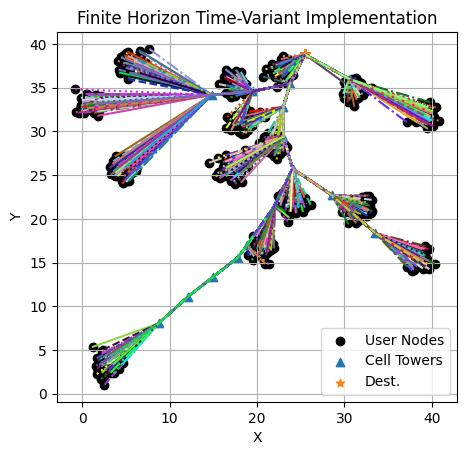

In [7]:
# Run stagewise FLPO
Scenarios=['smallCellNetData.pkl']
Costs_base_FLPO = []
Times_base_FLPO = []
Costs_parasdm_FLPO = []
Times_parasdm_FLPO = []
policyList = [[] for i in range(len(Scenarios))];
num_runs = 1;
for idx,scenario in enumerate(Scenarios):
    print(f'\n\n Scenario: ',idx+1,'Out of ',len(Scenarios))
    print('Base Flpo')
    with open(scenario, 'rb') as file:
        data = pickle.load(file)
    drones_2 = [[node, tuple(data['destinationLocation'][0]), 1.0] for node in data['nodeLocations']]
    beta_init = 1e-6 # initial beta value for the optimization.
    beta_f = 1e8 # final beta value for the optimization
    alpha = 3 # beta growth rate
    purturb = 1e-3 # random purturbation in optimization

    start_time1 = time.time();
    env=uav_flpo(drones_2,data['numFacilities'],blocks=None,
                ugv_factor=0,fcr=1e8,distance='sqeuclidean')
    env.train(beta_init=beta_init,beta_f=beta_f,alpha=alpha,
              purturb=purturb,method='powell',verbos=0)
    end_time1 = time.time();
    Costs_base_FLPO.append(env.return_total_cost())
    Times_base_FLPO.append(end_time1-start_time1)
    print(end_time1-start_time1)
    plt.figure()
    env.plot_routs(show_info=0, show_nums=0, save=1, show_ugv=0);

    # if idx==3:
    #     break

    # print('ParaSDM FLPO')
    # # Run Infinite Horizon FLPO
    # costs_para=[]
    # Times_para=[]
    # for run in range(num_runs):
    #     print('Run: ',run+1,'Out of ',num_runs);
    #     smallcell1 = SmallCellNet(scenario);
    #     smallcell1.init_params();
    #     smallcell1.init_cost_matrix();
    #     smallcell1.init_grad_matrix();
    #     smallcell1.init_action_mask();
    #     smallcell1.parameters();
    #     start_time2 = time.time();
    #     finalPol = optimizePolicyNParams_annealed(smallcell1, gamma = 1.0, beta_init = 1e-6, beta_max=1e7, beta_grow=3, sigma=1e-6,
    #     epsilon=0.0005, n_iters=50, n_iters_qi=201, gd_iters=200, n_iters_gi=500, allow_print=0, reward2cost=1);
    #     end_time2 = time.time();
    #     routes = getRoutes(smallcell1, finalPol);
    #     plt.figure();
    #     cost = plotRoutes(smallcell1, routes, 'ParaSDM Time Invariant FLPO');
    #     costs_para.append(cost);
    #     Times_para.append(end_time2-start_time2)
    #     policyList[idx].append(finalPol)
    #     print(end_time2-start_time2)
    # arg_min,min_value=np.argmin(costs_para),np.min(costs_para)
    # Costs_parasdm_FLPO.append(min_value)
    # Times_parasdm_FLPO.append(Times_para[arg_min])
    # mean_value=np.mean(costs_para)
    # Costs_parasdm_FLPO.append(mean_value)
    # Times_parasdm_FLPO.append(np.mean(Times_para))


# Infinite Horizon FLPO Implementation

# Environment

# Implementation

In [ ]:
# # env.print_routs();
# env.plot_routs(show_info=0, show_nums=0, save=1, show_ugv=0);
# facilities1 = env.Y_s

# cost = plotPolicyInf(smallcell1, finalPol, 'ParaSDM Time Invariant FLPO', printRoutes=False);

# print('total time (time variant) = ', end_time1 - start_time1);
# print('total cost (time variant) = ' , env.return_total_cost());
# print('\n');
# print('total time (time invariant) = ', end_time2 - start_time2);
# print('total cost (time invariant) = ' , cost);

([<matplotlib.axis.XTick at 0x147b1f2e0>], [Text(0, 0, '0')])

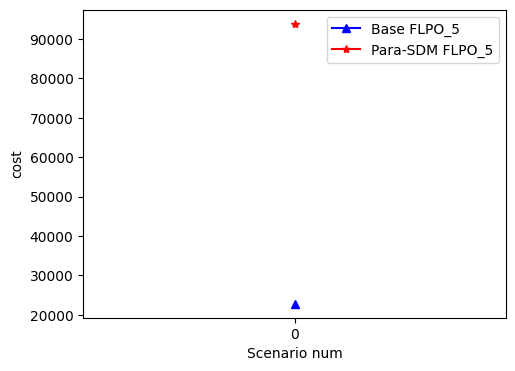

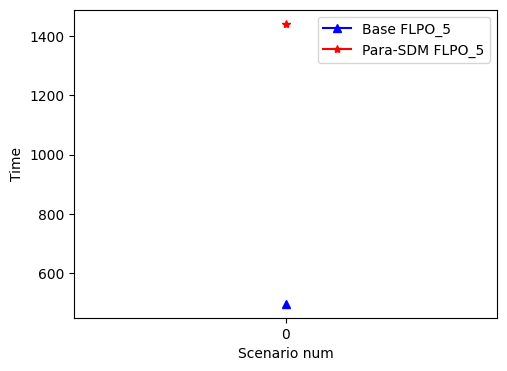

In [ ]:
Costs_base_FLPO_scenarios_1 = [Costs_base_FLPO[i] for i in range(0,len(Costs_base_FLPO),1)]
Costs_parasdm_FLPO_scenarios_1 = [Costs_parasdm_FLPO[i] for i in range(0,len(Costs_parasdm_FLPO),1)]
# Costs_base_FLPO_scenarios_2 = [Costs_base_FLPO[i] for i in range(1,len(Costs_base_FLPO)+1,2)]
# Costs_parasdm_FLPO_scenarios_2 = [Costs_parasdm_FLPO[i] for i in range(1,len(Costs_parasdm_FLPO)+1,2)]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(Costs_base_FLPO_scenarios_1,color='b',label=f'Base FLPO_{M_values[0]}',marker='^')
plt.plot(Costs_parasdm_FLPO_scenarios_1,color='r',label=f'Para-SDM FLPO_{M_values[0]}',marker='*')
plt.legend()
plt.xlabel('Scenario num')
plt.xticks(np.arange(N_scenarios))
plt.ylabel('cost')
# plt.subplot(1,2,2)
# plt.plot(Costs_base_FLPO_scenarios_2,color='b',label=f'Base FLPO_{M_values[1]}',marker='^')
# plt.plot(Costs_parasdm_FLPO_scenarios_2,color='r',label=f'Para-SDM FLPO_{M_values[1]}',marker='*')
# plt.legend()
# plt.title('Cost function comparison')
# plt.xlabel('Scenario num')
# plt.xticks(np.arange(N_scenarios))
# plt.ylabel('cost')


Times_base_FLPO_scenarios_1 = [Times_base_FLPO[i] for i in range(0,len(Times_base_FLPO),1)]
Times_parasdm_FLPO_scenarios_1 = [Times_parasdm_FLPO[i] for i in range(0,len(Times_parasdm_FLPO),1)]
# Times_base_FLPO_scenarios_2 = [Times_base_FLPO[i] for i in range(1,len(Times_base_FLPO)+1,2)]
# Times_parasdm_FLPO_scenarios_2 = [Times_parasdm_FLPO[i] for i in range(1,len(Times_parasdm_FLPO)+1,2)]

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(Times_base_FLPO_scenarios_1,color='b',label=f'Base FLPO_{M_values[0]}',marker='^')
plt.plot(Times_parasdm_FLPO_scenarios_1,color='r',label=f'Para-SDM FLPO_{M_values[0]}',marker='*')
plt.legend()
plt.xlabel('Scenario num')
plt.ylabel('Time')
plt.xticks(np.arange(N_scenarios))
# plt.subplot(1,2,2)
# plt.plot(Times_base_FLPO_scenarios_2,color='b',label=f'Base FLPO_{M_values[1]}',marker='^')
# plt.plot(Times_parasdm_FLPO_scenarios_2,color='r',label=f'Para-SDM FLPO_{M_values[1]}',marker='*')
# plt.legend()
# plt.title('Time comparison')
# plt.xlabel('Scenario num')
# plt.xticks(np.arange(N_scenarios))
# plt.ylabel('Time')

In [ ]:
beta=1E-8
gamma=1.0
action_mask = np.array([[1.0,1.0,0.0],
                     [1.0,1.0,1.0],
                     [0.0,1.0,1.0]])
finalValue=np.array([[3.0,2.0,1.0],
                     [0.0,-1.0,1.0],
                     [1.0,0.0,1.0]])
tv1 = finalValue.copy(); tv1[action_mask == 0] = np.inf;
print(tv1)
expo = np.exp((-beta/gamma) * (finalValue - np.min(tv1, axis= 0, keepdims=True)));#exponent of the q-function to get the final policy...
sumexpo = np.sum(expo, axis=0, keepdims= True);
finalPolicy = expo/sumexpo;
print(finalPolicy)

In [ ]:

smallcell1.action_space
P